In [1]:
%%time
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

CPU times: user 41 µs, sys: 20 µs, total: 61 µs
Wall time: 64.8 µs


In [2]:
%%time
### 生成输出目录的模块
import os
from datetime import datetime

def generate_output(disturb: bool, filename):
    slurm_job_id = os.environ.get('SLURM_JOB_ID')
    # Generate the folder name with the current date
    now = datetime.now()
    if disturb:
        folder_name = f"{slurm_job_id}_Graph_Rmv_Stoch_{now.strftime('%Y-%m-%d-%H-%M')}"
    else:
        folder_name = f"{slurm_job_id}_Graph_Rmv_Btwn_{now.strftime('%Y-%m-%d-%H-%M')}"

    # Create the output directory if it doesn't exist
    output_dir = os.path.join(os.getcwd(), folder_name)
    os.makedirs(output_dir, exist_ok=True)

    # Construct the full file path
    file_path = os.path.join(output_dir, filename)

    return file_path

CPU times: user 7 µs, sys: 3 µs, total: 10 µs
Wall time: 11.4 µs


In [3]:
%%time
import os

slurm_job_id = os.environ.get('SLURM_JOB_ID')
    
from datetime import datetime

import networkx as nx
from networkx.generators.community import LFR_benchmark_graph

n = 1000
tau1 = 2  # Power-law exponent for the degree distribution
tau2 = 1.1  # Power-law exponent for the community size distribution
mu = 0.1  # Mixing parameter
avg_deg = 25  # Average Degree
max_deg = int(0.1 * n)  # Max Degree
min_commu = 60  # Min Community Size
max_commu = int(0.1 * n)  # Max Community Size

G0 = LFR_benchmark_graph(
    n, tau1, tau2, mu, average_degree=avg_deg, max_degree=max_deg, min_community=min_commu, max_community=max_commu,
    seed=7
)

# Remove multi-edges and self-loops from G0
G0 = nx.Graph(G0)
selfloop_edges = list(nx.selfloop_edges(G0))
G0.remove_edges_from(selfloop_edges)

# Generate a timestamp for the output file names
now = datetime.now()

# Write the graph's edge list to a file
edge_output_file = f"{slurm_job_id}_edgelist_{now.strftime('%Y-%m-%d-%H-%M')}.txt"
nx.write_edgelist(G0, edge_output_file, delimiter=' ', data=False)

import numpy as np
# Get intrinsic membership and save it to a file
intrinsic_communities = {frozenset(G0.nodes[v]["community"]) for v in G0}
intrinsic_membership = np.empty(G0.number_of_nodes(), dtype=int)
for node in range(G0.number_of_nodes()):
    for index, inner_set in enumerate(intrinsic_communities):
        if node in inner_set:
            intrinsic_membership[node] = index
            break

membership_output_file = f"{slurm_job_id}_membership_{now.strftime('%Y-%m-%d-%H-%M')}.txt"
np.savetxt(membership_output_file, intrinsic_membership, delimiter=' ', fmt='%d')

# Get betweenness centrality and save it to a file
betweenness = list(nx.betweenness_centrality(G0).values())
betweenness_output_file = f"{slurm_job_id}_betweenness_{now.strftime('%Y-%m-%d-%H-%M')}.txt"
np.savetxt(betweenness_output_file, betweenness, delimiter=' ')

CPU times: user 8.45 s, sys: 13.8 s, total: 22.3 s
Wall time: 5.69 s


In [4]:
'''
### 读取存储的图的相关信息
### 从文件中读入内容并转化成 边列表
with open('edgelist_2023-07-11-17.txt', 'r') as file:
    lines = file.readlines()

### Process the lines and create a list of number pairs
edge_list = []
for line in lines:
    pair = tuple(map(int, line.strip().split()))
    edge_list.append(pair)

### Print the list of number pairs
#print(edge_list)

import networkx as nx

### 新建一个图 
G0 = nx.Graph()

### 向图添加边
G0.add_edges_from(edge_list)

### 记录有几个结点
N = G0.number_of_nodes()

### Load Community Info
import numpy as np

membership_list = "membership_2023-07-11-17.txt"
intrinsic_membership = np.loadtxt(membership_list, dtype=int)

btwn_file = "betweenness_2023-07-11-17.txt"
betweenness = np.loadtxt(btwn_file)
'''

'\n### 读取存储的图的相关信息\n### 从文件中读入内容并转化成 边列表\nwith open(\'edgelist_2023-07-11-17.txt\', \'r\') as file:\n    lines = file.readlines()\n\n### Process the lines and create a list of number pairs\nedge_list = []\nfor line in lines:\n    pair = tuple(map(int, line.strip().split()))\n    edge_list.append(pair)\n\n### Print the list of number pairs\n#print(edge_list)\n\nimport networkx as nx\n\n### 新建一个图 \nG0 = nx.Graph()\n\n### 向图添加边\nG0.add_edges_from(edge_list)\n\n### 记录有几个结点\nN = G0.number_of_nodes()\n\n### Load Community Info\nimport numpy as np\n\nmembership_list = "membership_2023-07-11-17.txt"\nintrinsic_membership = np.loadtxt(membership_list, dtype=int)\n\nbtwn_file = "betweenness_2023-07-11-17.txt"\nbetweenness = np.loadtxt(btwn_file)\n'

In [5]:
%%time
### 生成删除顶点的顺序 模块
import random
import networkx as nx
import numpy as np

def nodes_sample(G, disturb: bool, number_of_nodes: int, percent, betweenness):
    graph = G.copy()
    sample_size = int(number_of_nodes*percent)
    if disturb:
        removed_nodes = random.sample(range(number_of_nodes), sample_size)
        graph.remove_nodes_from(removed_nodes)
        if nx.is_connected(graph):
            return removed_nodes
    else: 
        removed_nodes = random.choices(range(number_of_nodes), betweenness, k=sample_size)
        graph.remove_nodes_from(removed_nodes)
        if nx.is_connected(graph):
            return removed_nodes
        
#nodes_sample(G0, N, 0.8)

import numpy as np
import json

def generate_remove_list(G, disturb: bool, number_of_nodes, betweenness):
    remove_procedure = []
    for percent in np.arange(0.05, 0.86, 0.05):
        ls = []
        while len(ls)<2:
            temp = nodes_sample(G = G, disturb = disturb, number_of_nodes = number_of_nodes, percent = percent, betweenness = betweenness)
            if not temp is None:
                ls.append(temp)
        remove_procedure.append(ls)
    filename = generate_output(disturb, "0Remove_Procedure.txt")
    with open(filename, 'w') as file:
        json.dump(remove_procedure, file)
    return remove_procedure

CPU times: user 3 µs, sys: 4 µs, total: 7 µs
Wall time: 10.5 µs


In [6]:
%%time
remove_procedure = generate_remove_list(G0, True, G0.number_of_nodes(), betweenness)

### 读取存储的删除顶点的顺序信息
'''
with open('Graph_Rmv_Stoch_2023-07-11-18/remove_procedure.txt', 'r') as file:
    loaded_data = json.load(file)
loaded_data == ls
'''

CPU times: user 1.59 s, sys: 0 ns, total: 1.59 s
Wall time: 1.59 s


"\nwith open('Graph_Rmv_Stoch_2023-07-11-18/remove_procedure.txt', 'r') as file:\n    loaded_data = json.load(file)\nloaded_data == ls\n"

In [7]:
%%time
index = []
for sublist_list in remove_procedure:
    sublist_index = []
    for sublist in sublist_list:
        temp = np.ones(G0.number_of_nodes(), dtype=bool)
        temp[sublist] = False
        sublist_index.append(temp)
    index.append(sublist_index)

CPU times: user 1.46 ms, sys: 0 ns, total: 1.46 ms
Wall time: 1.18 ms


In [8]:
%%time

import csv

def save_scores_to_csv(scores, disturb: bool, filename):
    """
    Saves a list of list of list to a CSV file with a double space separator.

    Args:
        scores (list): The list of list of list to be saved.
        disturb (bool): A boolean indicating if disturbance is present.
        filename (str): The name of the output CSV file.
    """
    # Construct the full file path
    file_path = generate_output(disturb, filename + ".csv")

    with open(file_path, 'a', newline='') as file:
        writer = csv.writer(file, delimiter=' ')
        for line in scores:
            writer.writerow(line)
            file.write('\n')

CPU times: user 1.58 ms, sys: 0 ns, total: 1.58 ms
Wall time: 2.13 ms


In [9]:
%%time
import os
import csv
from datetime import date

def save_to_csv(content, disturb: bool, filename):
    """
    Saves a list of 4-lists to a CSV file with a double space separator.
    
    Args:
        scores (list): The list of 4-lists to be saved.
        filename (str): The name of the output CSV file.
    """
    # Construct the full file path
    file_path = generate_output(disturb, filename+".csv")

    with open(file_path, 'w', newline='') as file:
        writer = csv.writer(file, delimiter=' ')
        for content_list in content:
            writer.writerow(content_list)

CPU times: user 9 µs, sys: 0 ns, total: 9 µs
Wall time: 12.6 µs


In [10]:
%%time
from auxpack.eval_embd import eval_embd as EE
from clusim.clustering import Clustering

D=20
K = len(np.unique(intrinsic_membership))
wk=32

CPU times: user 284 ms, sys: 167 ms, total: 450 ms
Wall time: 945 ms


In [11]:
%%time
def Plot_Separate(MEAN, STD, filename):
    # Generate x-coordinates for the data points with a step size of 0.05
    x_values = np.arange(0.05, 0.86, 0.05)

    # Create a figure with four subplots
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True)

    # Plot the lines for columns 1 in the first subplot
    ax1.plot(x_values, [MEAN[i][0] for i in range(len(MEAN))], label='Column 1', color='tab:red')
    ax1.fill_between(x_values, np.subtract([MEAN[i][0] for i in range(len(MEAN))], [STD[i][0] for i in range(len(STD))]),
                     np.add([MEAN[i][0] for i in range(len(MEAN))], [STD[i][0] for i in range(len(STD))]), alpha=0.2, color='tab:red')
    ax1.set_ylabel('Y-coordinate')
    ax1.legend()

    # Plot the lines for columns 2 in the second subplot
    ax2.plot(x_values, [MEAN[i][1] for i in range(len(MEAN))], label='Column 2', color='tab:green')
    ax2.fill_between(x_values, np.subtract([MEAN[i][1] for i in range(len(MEAN))], [STD[i][1] for i in range(len(STD))]),
                     np.add([MEAN[i][1] for i in range(len(MEAN))], [STD[i][1] for i in range(len(STD))]), alpha=0.2, color='tab:green')
    ax2.set_ylabel('Y-coordinate')
    ax2.legend()

    # Plot the lines for columns 3 in the third subplot
    ax3.plot(x_values, [MEAN[i][2] for i in range(len(MEAN))], label='Column 3', color='tab:blue')
    ax3.fill_between(x_values, np.subtract([MEAN[i][2] for i in range(len(MEAN))], [STD[i][2] for i in range(len(STD))]),
                     np.add([MEAN[i][2] for i in range(len(MEAN))], [STD[i][2] for i in range(len(STD))]), alpha=0.2, color='tab:blue')
    ax3.set_ylabel('Y-coordinate')
    ax3.legend()
    
    # Plot the lines for columns 4 in the fourth subplot
    ax4.plot(x_values, [MEAN[i][3] for i in range(len(MEAN))], label='Column 4', color='tab:orange')
    ax4.fill_between(x_values, np.subtract([MEAN[i][3] for i in range(len(MEAN))], [STD[i][3] for i in range(len(STD))]),
                     np.add([MEAN[i][3] for i in range(len(MEAN))], [STD[i][3] for i in range(len(STD))]), alpha=0.2, color='tab:orange')
    ax4.set_xlabel('X-coordinate')
    ax4.set_ylabel('Y-coordinate')

    # Remove the legend for "Column 4" in the fourth subplot
    ax4.legend(handles=ax4.lines[:-1])

    # Set the x-axis scale
    plt.xticks(np.arange(0.0, 0.9, 0.05))

    # Automatically determine the lower bound for the y-axis
    y_min = min([min(y) for y in MEAN])
    y_max = max([max(y) for y in MEAN])
    y_range = y_max - y_min
    y_offset = y_range * 0.1  # Adjust the offset as needed
    y_lower = y_min - y_offset - 0.06
    y_upper = 1.1
    ax1.set_ylim(y_lower, y_upper)
    ax2.set_ylim(y_lower, y_upper)
    ax3.set_ylim(y_lower, y_upper)
    ax4.set_ylim(y_lower, y_upper)

    # Set the y-axis tick marks
    y_tick_step = 0.03
    y_ticks = np.arange(y_lower, y_upper, y_tick_step)
    ax1.set_yticks(y_ticks)
    ax2.set_yticks(y_ticks)
    ax3.set_yticks(y_ticks)
    ax4.set_yticks(y_ticks)

    # Adjust the figure size
    fig.set_size_inches(10, 20)  # Increase the height of the figure

    ##########################
    filename = filename+"_SEPARATE"
    ##########################

    file_path = generate_output(True, filename+".png")
    plt.savefig(file_path)    

    # Show the plot
    plt.show()

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 7.87 µs


In [12]:
%%time
import numpy as np
import matplotlib.pyplot as plt

def Plot_Combine(MEAN, STD, filename):
    # Generate x-coordinates for the data points with a step size of 0.05
    x_values = np.arange(0.05, 0.86, 0.05)

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

    # Plot the lines for columns 1 and 3 in the first subplot
    ax1.plot(x_values, [MEAN[i][0] for i in range(len(MEAN))], label='Column 1', color='tab:red')
    ax1.plot(x_values, [MEAN[i][2] for i in range(len(MEAN))], label='Column 3', color='tab:blue')
    ax1.fill_between(x_values, np.subtract([MEAN[i][0] for i in range(len(MEAN))], [STD[i][0] for i in range(len(STD))]),
                     np.add([MEAN[i][0] for i in range(len(MEAN))], [STD[i][0] for i in range(len(STD))]), alpha=0.2, color='tab:red')
    ax1.fill_between(x_values, np.subtract([MEAN[i][2] for i in range(len(MEAN))], [STD[i][2] for i in range(len(STD))]),
                     np.add([MEAN[i][2] for i in range(len(MEAN))], [STD[i][2] for i in range(len(STD))]), alpha=0.2, color='tab:blue')
    ax1.set_ylabel('Y-coordinate')
    ax1.legend()

    # Plot the lines for columns 2 and 4 in the second subplot
    ax2.plot(x_values, [MEAN[i][1] for i in range(len(MEAN))], label='Column 2', color='tab:green')
    ax2.plot(x_values, [MEAN[i][3] for i in range(len(MEAN))], label='Column 4', color='tab:orange')
    ax2.fill_between(x_values, np.subtract([MEAN[i][1] for i in range(len(MEAN))], [STD[i][1] for i in range(len(STD))]),
                     np.add([MEAN[i][1] for i in range(len(MEAN))], [STD[i][1] for i in range(len(STD))]), alpha=0.2, color='tab:green')
    ax2.fill_between(x_values, np.subtract([MEAN[i][3] for i in range(len(MEAN))], [STD[i][3] for i in range(len(STD))]),
                     np.add([MEAN[i][3] for i in range(len(MEAN))], [STD[i][3] for i in range(len(STD))]), alpha=0.2, color='tab:orange')
    ax2.set_xlabel('X-coordinate')
    ax2.set_ylabel('Y-coordinate')
    ax2.legend()

    # Set the x-axis scale
    plt.xticks(np.arange(0.0, 0.9, 0.05))

    # Automatically determine the lower bound for the y-axis
    y_min = min([min(y) for y in MEAN])
    y_max = max([max(y) for y in MEAN])
    y_range = y_max - y_min
    y_offset = y_range * 0.1  # Adjust the offset as needed
    y_lower = y_min - y_offset - 0.06
    y_upper = 1.1
    ax1.set_ylim(y_lower, y_upper)
    ax2.set_ylim(y_lower, y_upper)

    # Set the y-axis tick marks
    y_tick_step = 0.03
    y_ticks = np.arange(y_lower, y_upper, y_tick_step)
    ax1.set_yticks(y_ticks)
    ax2.set_yticks(y_ticks)

    # Adjust the figure size
    fig.set_size_inches(10, 12)  # Increase the height of the figure

    ##########################
    filename = filename+"_COMBINE"
    ##########################

    file_path = generate_output(True, filename+".png")
    plt.savefig(file_path)    

    # Show the plot
    plt.show()

CPU times: user 283 ms, sys: 54.4 ms, total: 337 ms
Wall time: 645 ms


In [13]:
%%time
import numpy as np
import matplotlib.pyplot as plt

def Plot_Total(MEAN, STD, filename):
    # Generate x-coordinates for the data points with a step size of 0.05
    x_values = np.arange(0.05, 0.86, 0.05)

    # Create a figure and axes
    fig, ax = plt.subplots()

    # Plot the lines for columns 1 and 3 in the first subplot
    ax.plot(x_values, [MEAN[i][0] for i in range(len(MEAN))], label='Column 1', color='tab:red')
    ax.plot(x_values, [MEAN[i][2] for i in range(len(MEAN))], label='Column 3', color='tab:blue')
    ax.fill_between(x_values, np.subtract([MEAN[i][0] for i in range(len(MEAN))], [STD[i][0] for i in range(len(STD))]),
                     np.add([MEAN[i][0] for i in range(len(MEAN))], [STD[i][0] for i in range(len(STD))]), alpha=0.2, color='tab:red')
    ax.fill_between(x_values, np.subtract([MEAN[i][2] for i in range(len(MEAN))], [STD[i][2] for i in range(len(STD))]),
                     np.add([MEAN[i][2] for i in range(len(MEAN))], [STD[i][2] for i in range(len(STD))]), alpha=0.2, color='tab:blue')

    # Plot the lines for columns 2 and 4 in the second subplot
    ax.plot(x_values, [MEAN[i][1] for i in range(len(MEAN))], label='Column 2', color='tab:green')
    ax.plot(x_values, [MEAN[i][3] for i in range(len(MEAN))], label='Column 4', color='tab:orange')
    ax.fill_between(x_values, np.subtract([MEAN[i][1] for i in range(len(MEAN))], [STD[i][1] for i in range(len(STD))]),
                     np.add([MEAN[i][1] for i in range(len(MEAN))], [STD[i][1] for i in range(len(STD))]), alpha=0.2, color='tab:green')
    ax.fill_between(x_values, np.subtract([MEAN[i][3] for i in range(len(MEAN))], [STD[i][3] for i in range(len(STD))]),
                     np.add([MEAN[i][3] for i in range(len(MEAN))], [STD[i][3] for i in range(len(STD))]), alpha=0.2, color='tab:orange')

    # Set labels and title
    ax.set_xlabel('X-coordinate')
    ax.set_ylabel('Y-coordinate')
    ax.set_title('Merged Plot')

    # Set the x-axis scale
    plt.xticks(np.arange(0.0, 0.9, 0.05))

    # Automatically determine the lower bound for the y-axis
    y_min = min([min(y) for y in MEAN])
    y_max = max([max(y) for y in MEAN])
    y_range = y_max - y_min
    y_offset = y_range * 0.1  # Adjust the offset as needed
    y_lower = y_min - y_offset - 0.06
    y_upper = 1.1
    ax.set_ylim(y_lower, y_upper)

    # Set the y-axis tick marks
    y_tick_step = 0.03
    y_ticks = np.arange(y_lower, y_upper, y_tick_step)
    ax.set_yticks(y_ticks)

    # Add a legend
    ax.legend()

    # Adjust the figure size
    fig.set_size_inches(10, 6)
    ##########################
    filename = filename+"_TOTAL"
    ##########################

    file_path = generate_output(True, filename+".png")
    plt.savefig(file_path)    

    # Show the plot
    plt.show()

CPU times: user 3 µs, sys: 3 µs, total: 6 µs
Wall time: 8.11 µs


In [14]:
%%time
from gem.embedding.hope import HOPE
from gem.embedding.lap import LaplacianEigenmaps
from auxpack.lle import lle
from auxpack.DeepWalk import DeepWalk
from karateclub import MNMF
from karateclub import MNMF
from ge import LINE
from node2vec import Node2Vec

def perform_hope_embedding(G, realize, D, _, __):
    G_copy = G.copy()
    G_copy.remove_nodes_from(realize)
    hope_model = HOPE(d=D, beta=0.01)
    embd = hope_model.learn_embedding(graph=G_copy, is_weighted=False, no_python=True)
    return embd

def perform_laplacian_embedding(G, realize, D, _, __):
    G_copy = G.copy()
    G_copy.remove_nodes_from(realize)
    lap_model = LaplacianEigenmaps(d=D)
    embd = lap_model.learn_embedding(graph=G_copy, is_weighted=False, no_python=True)
    return embd

def perform_lle_embedding(G, realize, D, _, __):
    G_copy = G.copy()
    G_copy.remove_nodes_from(realize)
    embd = lle(G_copy, D)
    return embd

def perform_deepwalk_embedding(G, realize, D, _, wk=32):
    G_copy = G.copy()
    G_copy.remove_nodes_from(realize)
    model = DeepWalk(dimensions=D, walk_length=16, window_size=10, walk_number=10, workers=wk)
    model.fit(G_copy)
    embd = model.get_embedding()
    return embd

def perform_mnmf_embedding(G, realize, D, _, __):
    G_copy = G.copy()
    G_copy.remove_nodes_from(realize)
    H = nx.relabel.convert_node_labels_to_integers(G_copy)
    MNMF_model = MNMF(dimensions=D, clusters=K, lambd=0.2, alpha=0.05, beta=0.05, iterations=100, lower_control=1e-15, eta=5.0, seed=42)
    MNMF_model.fit(H)
    embd = MNMF_model.get_embedding()
    return embd

def calculate_score(embd, intrinsic_membership, K):
    intrin_list = intrinsic_membership
    intrin_Clus = Clustering({i: [intrin_list[i]] for i in range(len(intrin_list))})
    score = EE(K, intrin_list, intrin_Clus, embd)
    return score

def perform_line_embedding(G, realize, D, _, __):
    G_copy = G.copy()
    G_copy.remove_nodes_from(realize)
    model = LINE(G_copy, embedding_size=D, order='first')
    model.train(batch_size=8192, epochs=50, verbose=0)
    LINE_embd = model.get_embeddings()
    embd = list(LINE_embd.values())
    return embd

def perform_node2vec_embedding(G, realize, D, idx, wk=32):
    G_copy = G.copy()
    G_copy.remove_nodes_from(realize)
    node2vec_model = Node2Vec(G_copy, dimensions=D, walk_length=16, num_walks=10, workers=wk, quiet=True)
    node2vec_fit = node2vec_model.fit(window=10, min_count=1, batch_words=20000)
    nodes_range = np.array(range(G.number_of_nodes()))
    nodes = [str(x) for x in nodes_range[idx]]
    embd = np.array([node2vec_fit.wv[node] for node in nodes])
    return embd

def Comprehensive_Processing(G, D, intrinsic_membership, remove_procedure, index, method: int):
    labels = ["1HOPE", "2LAP", "3LLE", "4DeepWalk", "5MNMF", "6LINE", "7Node2Vec"]
    print(labels[method-1])
    MEAN = []
    STD = []

    embedding_methods = {
        1: (perform_hope_embedding, "HOPE"),
        2: (perform_laplacian_embedding, "LAP"),
        3: (perform_lle_embedding, "LLE"),
        4: (perform_deepwalk_embedding, "DeepWalk"),
        5: (perform_mnmf_embedding, "MNMF"),
        6: (perform_line_embedding, "LINE"),
        7: (perform_node2vec_embedding, "Node2Vec")
    }

    embedding_func, method_label = embedding_methods[method]

    for rp, idx in zip(remove_procedure, index):
        scores = []
        for realize, idxx in zip(rp, idx):
            G_copy = G.copy()
            embd = embedding_func(G_copy, realize, D, idxx, 32)
            K = len(np.unique(intrinsic_membership[idxx]))
            score = calculate_score(embd, intrinsic_membership[idxx], K)
            scores.append(score)

        array = np.array(scores)
        mean = np.mean(array, axis=0)
        std = np.std(array, axis=0)
        MEAN.append(mean)
        STD.append(std)
        save_scores_to_csv(scores, True, labels[method-1] + "_SCORES")

    save_to_csv(MEAN, True, labels[method-1] + "_MEAN")
    save_to_csv(STD, True, labels[method-1] + "_STD")
    Plot_Separate(MEAN, STD, labels[method-1])
    Plot_Combine(MEAN, STD, labels[method-1])
    Plot_Total(MEAN, STD, labels[method-1])

CPU times: user 1.85 s, sys: 1.21 s, total: 3.06 s
Wall time: 7.79 s


1HOPE


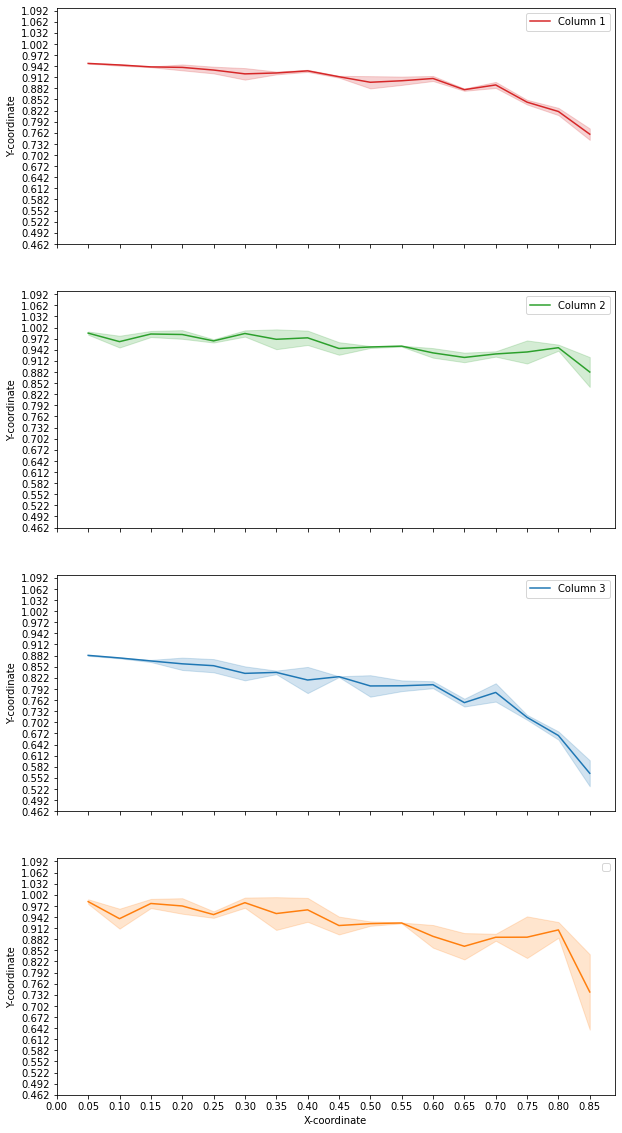

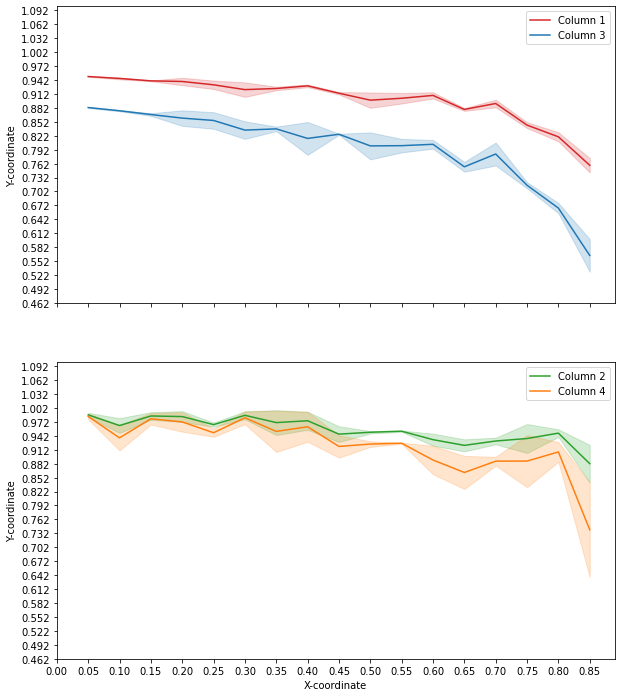

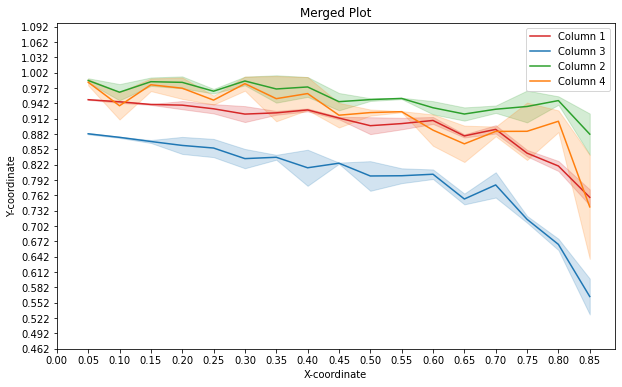

CPU times: user 11min 20s, sys: 14min 36s, total: 25min 57s
Wall time: 18.3 s


In [15]:
%%time
Comprehensive_Processing(G0, D, intrinsic_membership, remove_procedure, index, 1)

2LAP


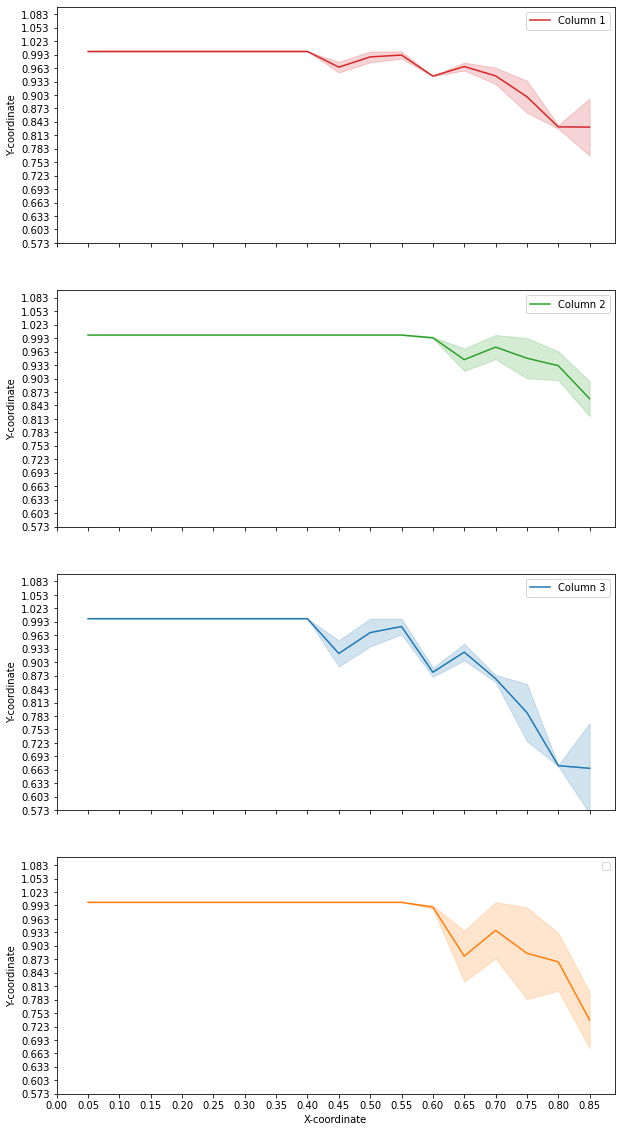

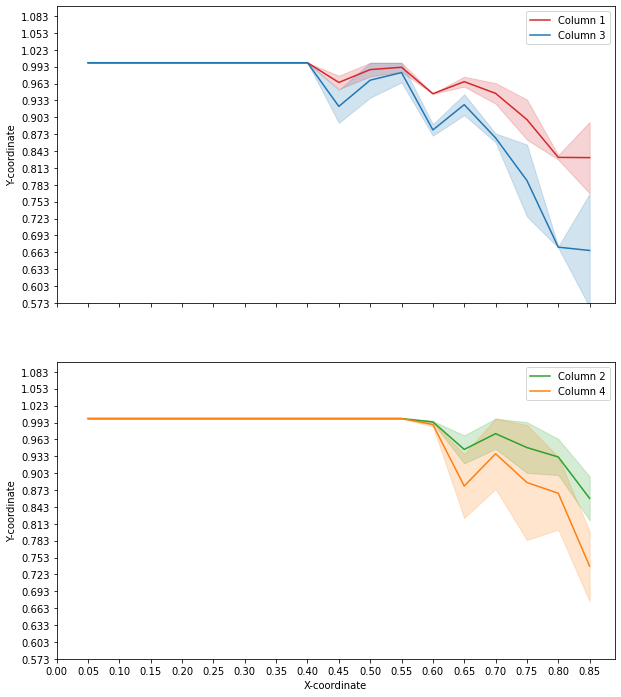

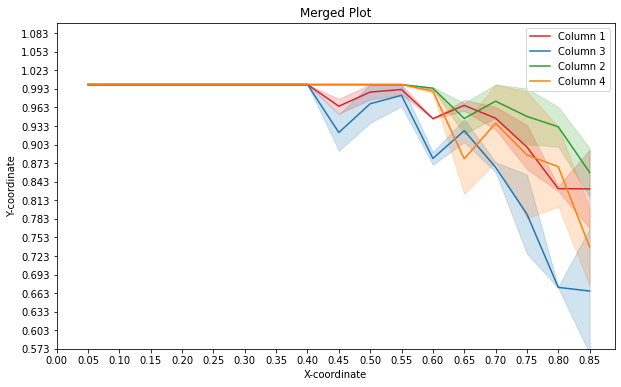

CPU times: user 11min 52s, sys: 15min 15s, total: 27min 7s
Wall time: 20.3 s


In [16]:
%%time
Comprehensive_Processing(G0, D, intrinsic_membership, remove_procedure, index, 2)

3LLE


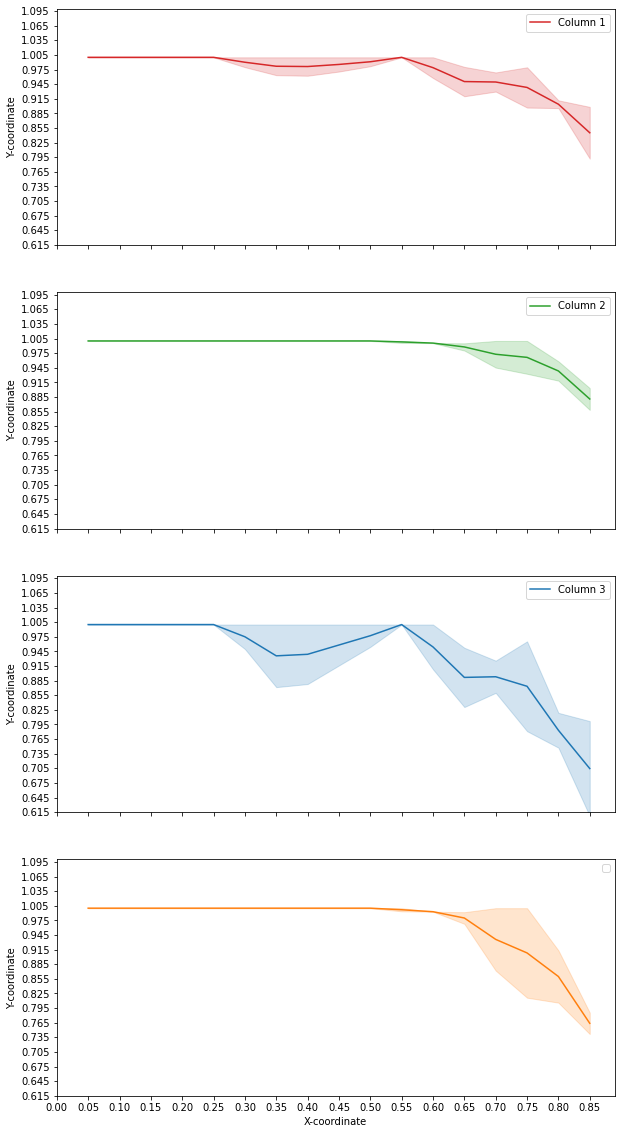

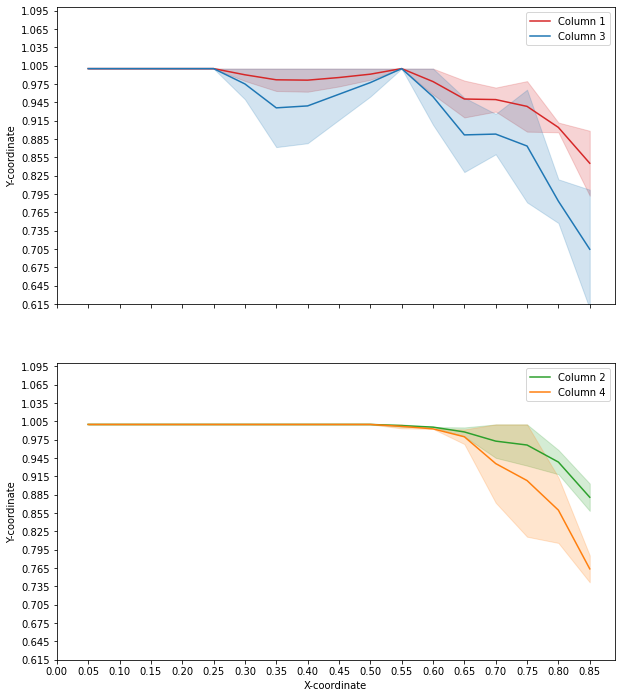

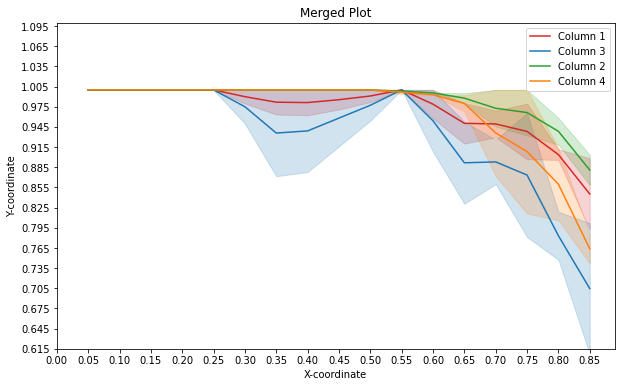

CPU times: user 15min 34s, sys: 23min 5s, total: 38min 40s
Wall time: 27.8 s


In [17]:
%%time
Comprehensive_Processing(G0, D, intrinsic_membership, remove_procedure, index, 3)

4DeepWalk


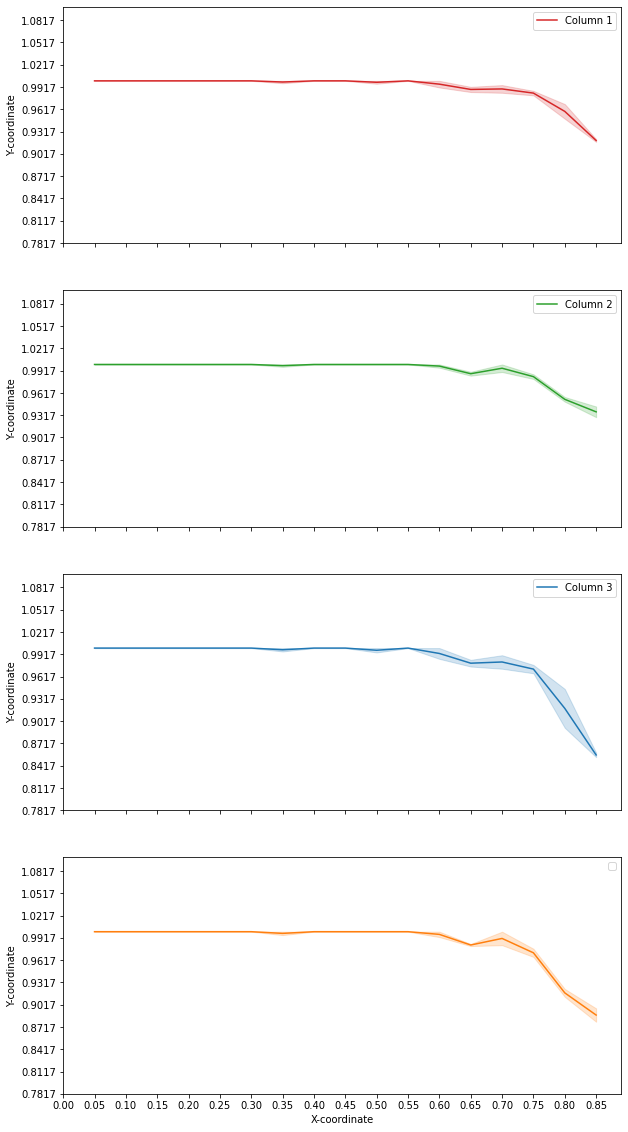

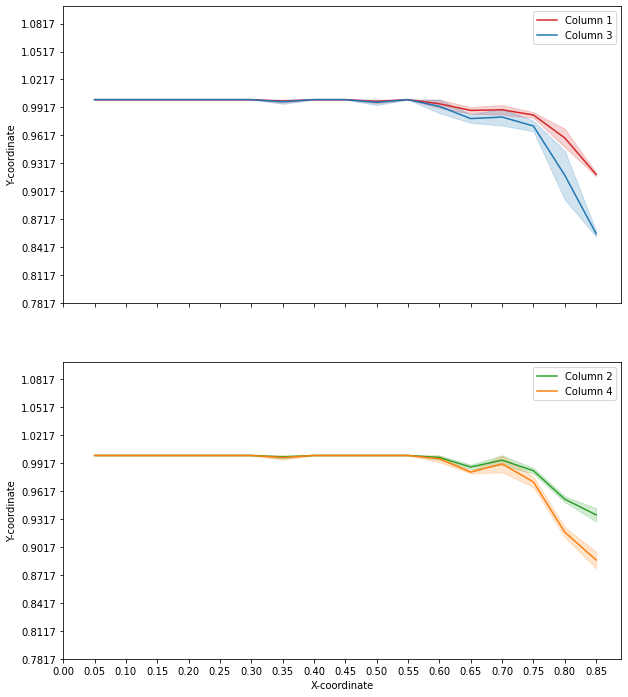

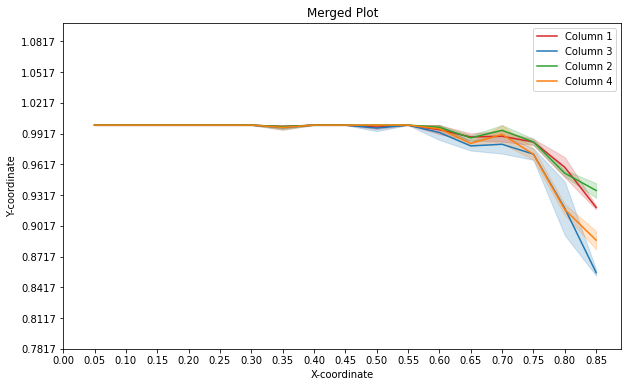

CPU times: user 9min 17s, sys: 9min 2s, total: 18min 19s
Wall time: 24.4 s


In [18]:
%%time
Comprehensive_Processing(G0, D, intrinsic_membership, remove_procedure, index, 4)

5MNMF


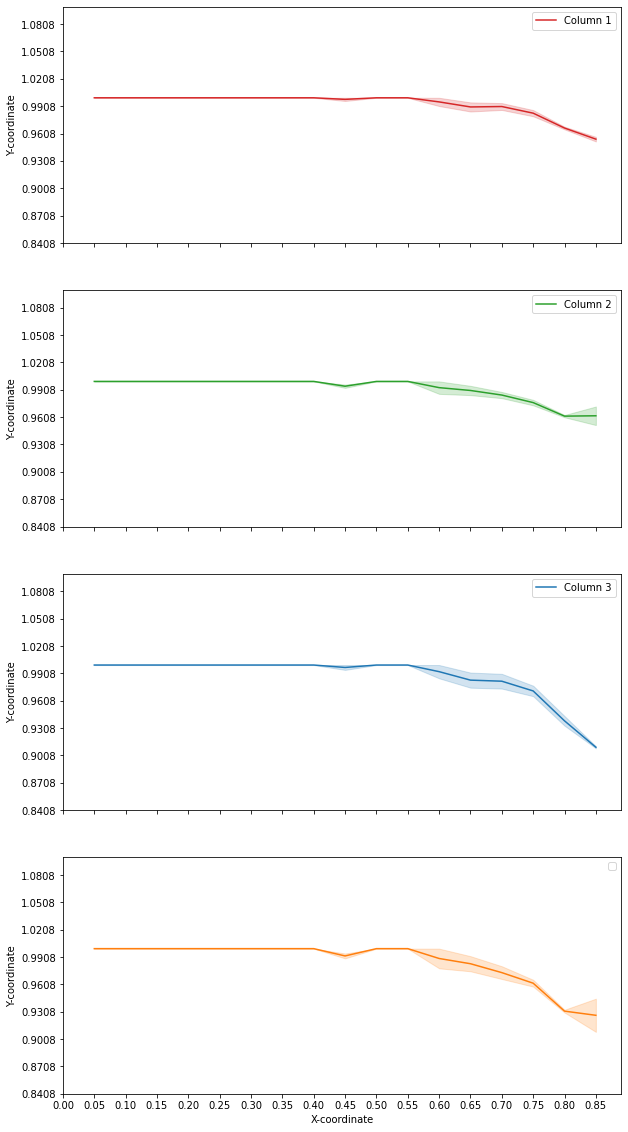

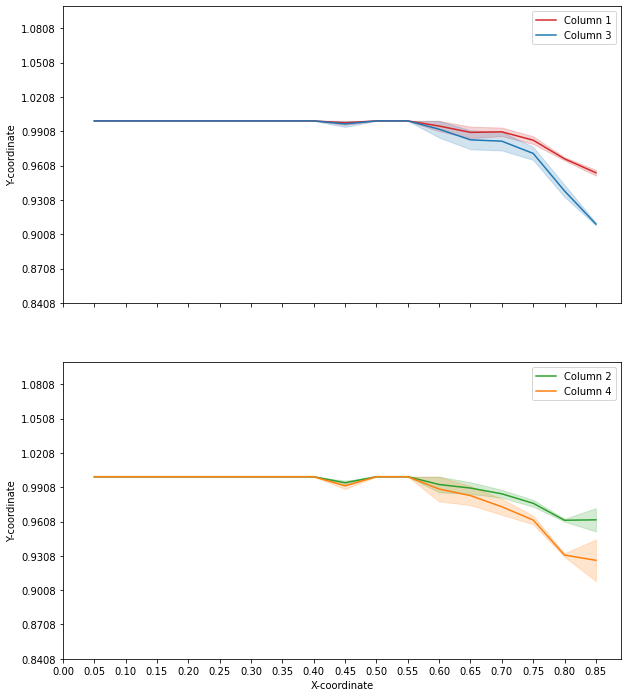

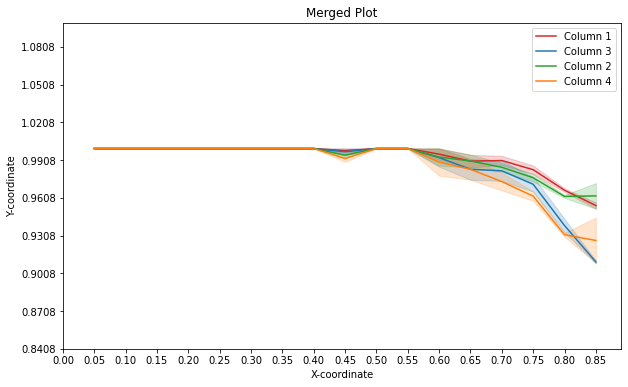

CPU times: user 13min 39s, sys: 26min 45s, total: 40min 25s
Wall time: 42.7 s


In [19]:
%%time
Comprehensive_Processing(G0, D, intrinsic_membership, remove_procedure, index, 5)

6LINE


2023-07-14 00:19:06.554617: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-14 00:19:08.362725: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 730 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:02:00.0, compute capability: 8.0
2023-07-14 00:19:08.364053: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 37113 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:41:00.0, compute capability: 8.0
2023-07-14 00:19:08.365013: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device

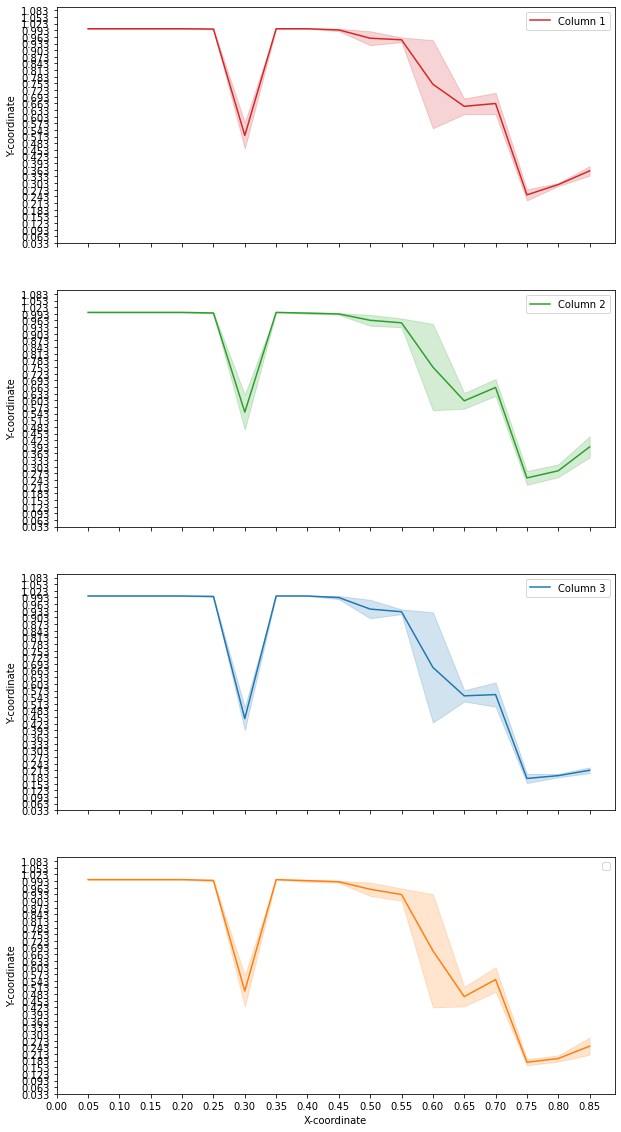

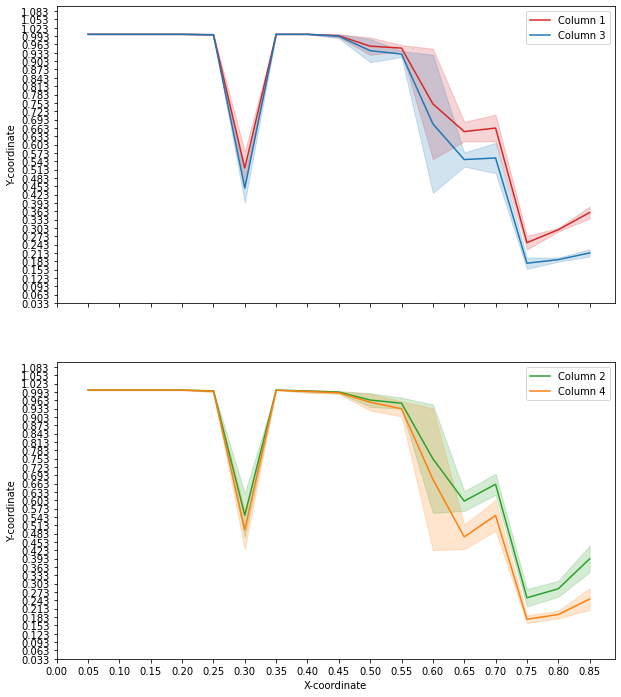

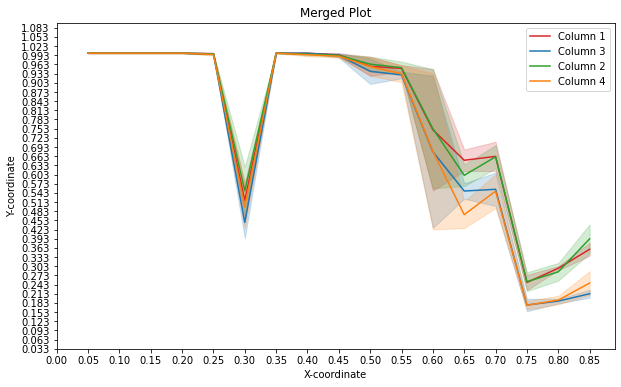

CPU times: user 10min 38s, sys: 9min 22s, total: 20min
Wall time: 1min 28s


In [20]:
%%time
Comprehensive_Processing(G0, D, intrinsic_membership, remove_procedure, index, 6)

7Node2Vec


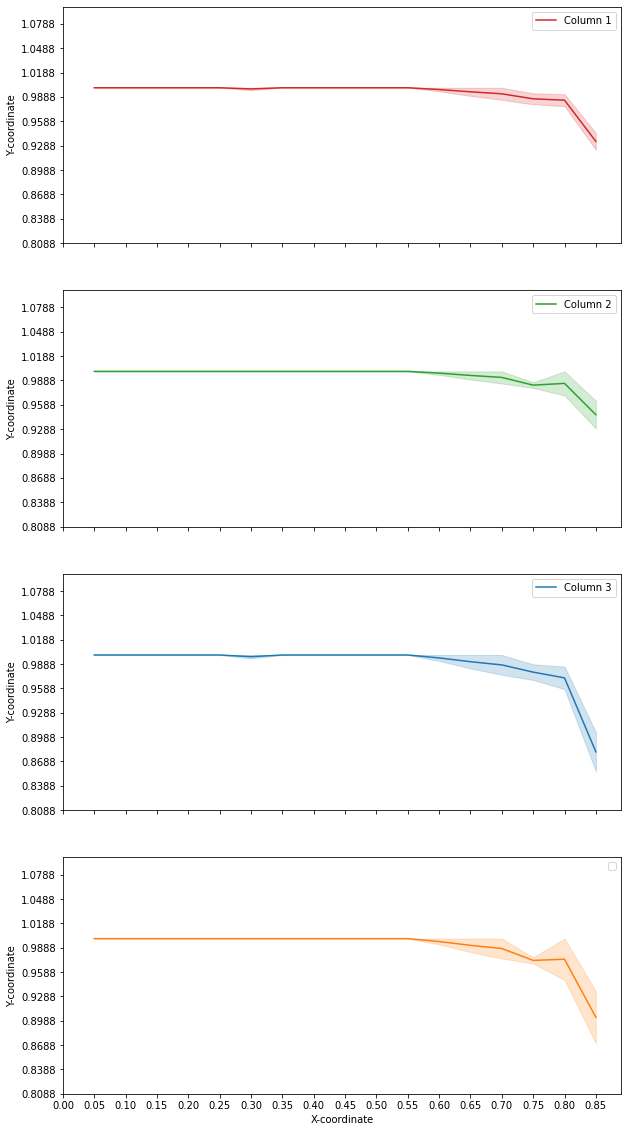

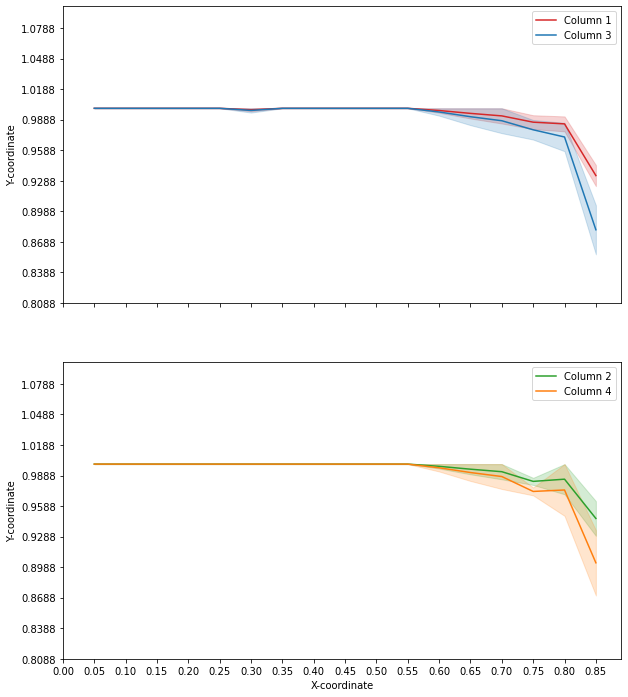

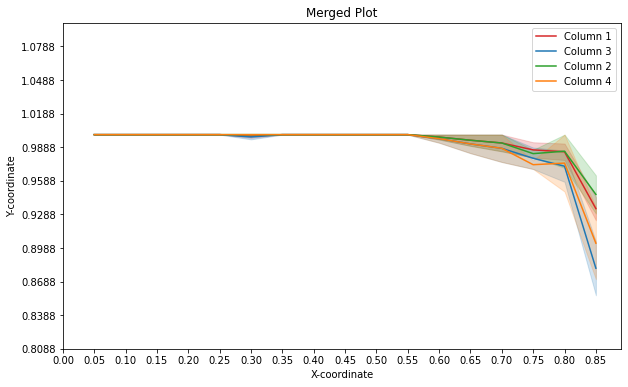

CPU times: user 12min 51s, sys: 9min 11s, total: 22min 3s
Wall time: 3min 43s


In [21]:
%%time
Comprehensive_Processing(G0, D, intrinsic_membership, remove_procedure, index, 7)